In [1]:
import numpy as np
import cv2
import glob
from moviepy.editor import VideoFileClip
from plotting_helpers import plot_images
from vehicle_features import get_hog_features
from vehicle_search import generate_search_windows, draw_boxes
from vehicle_model import build_model
from vehicle_processing import process_image
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')

# Histogram of Oriented Gradients (HOG)

### Load sample images

In [2]:
sample_files = glob.glob('test_images/*.jpg')
sample_images = []

for file in sample_files:
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    sample_images.append(img)

img = np.copy(sample_images[0])
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

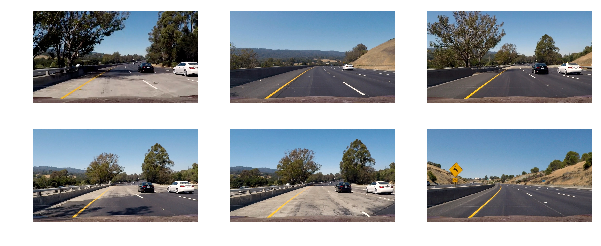

In [3]:
plot_images(sample_images, cols=3, figsize=(10, 4))

In [4]:
pixel_per_cell = 8
cell_per_block = 2
orientations = 9
visualise = True
feature_vector = True

car_img = img[360:(360+180), (1280-200):1280]
car_gray = gray[360:(360+180), (1280-200):1280]

features, hog_img = get_hog_features(car_gray, 
                                     orientations=orientations,
                                     pix_per_cell=pixel_per_cell,
                                     cell_per_block=cell_per_block,
                                     visualise=visualise,
                                     feature_vector=feature_vector)

In [5]:
features.shape

(18144,)

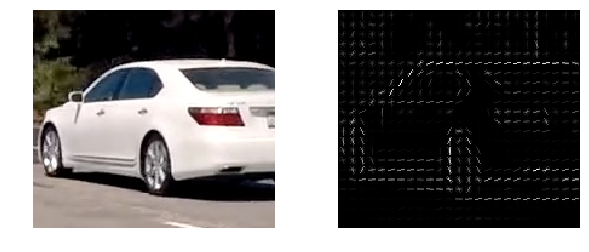

In [6]:
plot_images([car_img, hog_img], cols=2, figsize=(10, 4))

# HOG Classifier

## Feature Extraction, Training and Prediction

In [7]:
%%time

color_space = 'LUV'           # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orientations = 9              # HOG orientations
pix_per_cell = 8              # HOG pixels per cell
cell_per_block = 2            # HOG cells per block
hog_channel = 'ALL'           # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16)       # Spatial binning dimensions
hist_bins = 16                # Number of histogram bins
spatial_feat = True           # Spatial features on or off
hist_feat = True              # Histogram features on or off
hog_feat = True               # HOG features on or off

svc, X_scaler = build_model(color_space=color_space,
                            orientations=orientations,
                            pix_per_cell=pix_per_cell,
                            cell_per_block=cell_per_block,
                            hog_channel=hog_channel,
                            spatial_size=spatial_size,
                            hist_bins=hist_bins,
                            spatial_feat=spatial_feat,
                            hist_feat=hist_feat,
                            hog_feat=hog_feat)

Using existing files "svc_ba7bca055e3132dc9238f4a55e1b75dd.p" and "scaler_ba7bca055e3132dc9238f4a55e1b75dd.p"...
CPU times: user 0 ns, sys: 4 ms, total: 4 ms
Wall time: 508 µs


## Model Performance

Using: 9 orientations 8 pixels per cell and 2 cells per block

Feature vector length: 1764

0.15 Seconds to train SVC...

Test Accuracy of SVC = 0.9763

My SVC predicts:
```
 [ 1.  1.  0.  0.  1.  1.  0.  1.  1.  1.  1.  0.  0.  0.  0.  0.  1.  1.]
```

For these 18 labels:
```
 [ 1.  1.  0.  0.  1.  1.  0.  1.  1.  1.  1.  0.  0.  0.  0.  0.  1.  1.]
```

0.00122 Seconds to predict 18 labels with SVC


## Accuracy Performance of Color Spaces

#### Hog Channel 0

```
| RGB    | 0.9527 |
| HSV    | 0.9613 |
| LUV    | 0.9634 |
| HLS    | 0.9656 |
| YUV    | 0.9441 |
| YCrCb  | 0.9634 |
```

#### Hog Channel 1

```
| RGB    | 0.9527 |
| HSV    | 0.9355 |
| LUV    | 0.9677 |
| HLS    | 0.9613 |
| YUV    | 0.9763 |
| YCrCb  | 0.972  |
```

#### Hog Channel 2

```
| RGB    | 0.9527 |
| HSV    | 0.9591 |
| LUV    | 0.972  |
| HLS    | 0.9376 |
| YUV    | 0.957  |
| YCrCb  | 0.957  |
```

#### Hog Channel ALL

```
| RGB    | 0.9613 |
| HSV    | 0.9828 |
| LUV    | 0.9935 |
| HLS    | 0.9785 |
| YUV    | 0.9914 |
| YCrCb  | 0.9935 |
```

# Sliding Window

## Scales and Overlap

In [8]:
windows = generate_search_windows(img)

In [9]:
windows_img = draw_boxes(img, windows, color=(255, 80, 0))

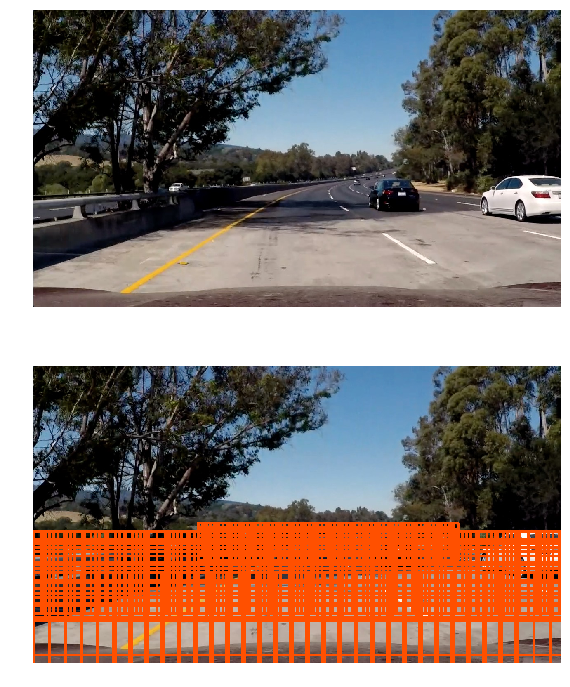

In [10]:
plot_images([img, windows_img], cols=1, figsize=(10, 12))

# Pipeline

In [11]:
output_imgs = []

for sample in sample_images:
    win_img, heat_img, label_img = process_image(sample,
                                                 windows=windows,
                                                 clf=svc,
                                                 scaler=X_scaler,
                                                 color_space=color_space,
                                                 spatial_size=spatial_size,
                                                 hist_bins=hist_bins,
                                                 orientations=orientations,
                                                 pix_per_cell=pix_per_cell,
                                                 cell_per_block=cell_per_block,
                                                 hog_channel=hog_channel,
                                                 spatial_feat=spatial_feat,
                                                 hist_feat=hist_feat,
                                                 hog_feat=hog_feat)
    output_imgs.append(win_img)
    output_imgs.append(heat_img)
    output_imgs.append(label_img)

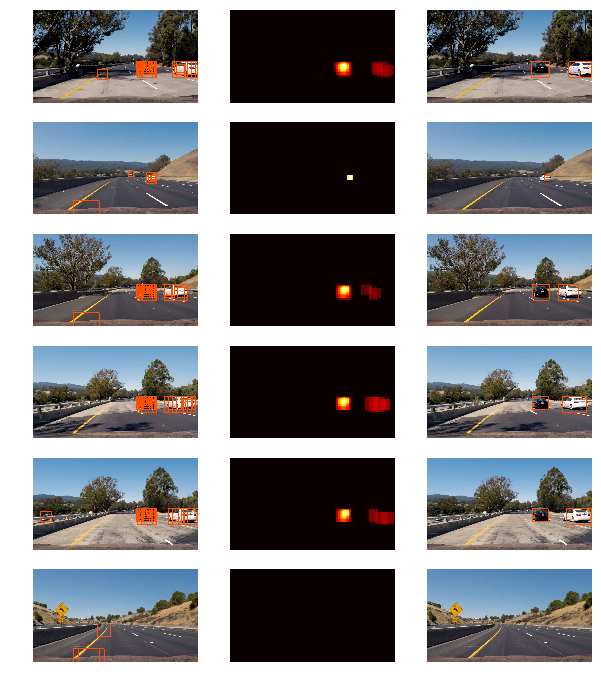

In [12]:
plot_images(output_imgs, cols=3, figsize=(10, 12), cmap='hot')

# Video Implementation

In [13]:
def process_frame(image):
    try:
        _, _, label_img = process_image(image,
                                        windows=windows,
                                        clf=svc,
                                        scaler=X_scaler,
                                        color_space=color_space,
                                        spatial_size=spatial_size,
                                        hist_bins=hist_bins,
                                        orientations=orientations,
                                        pix_per_cell=pix_per_cell,
                                        cell_per_block=cell_per_block,
                                        hog_channel=hog_channel,
                                        spatial_feat=spatial_feat,
                                        hist_feat=hist_feat,
                                        hog_feat=hog_feat)
        frame = label_img
    except Exception as e:
        frame = image
        print(e)
    finally:
        return frame

In [14]:
# video_output = 'project_video_output.mp4'
# clip = VideoFileClip('project_video.mp4')
video_output = 'test_video_output.mp4'
clip = VideoFileClip('test_video.mp4')
out_clip = clip.fl_image(process_frame)
out_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|█████████▋| 38/39 [02:50<00:04,  4.57s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

